
## Полезные ссылки и литература

#### Этот блокнот основан на посте:
https://github.com/msurtsukov/ae_vae_gan/blob/master/VAE.ipynb  
Можно сказать что это репост кода + некая творческай постобработка.

#### Литература и ссылки из поста:
Теоретическая часть основана на статье:  
[1] Tutorial on Variational Autoencoders, Carl Doersch, 2016, https://arxiv.org/abs/1606.05908  
и фактически является ее кратким изложением

Многие картинки взяты из блога Isaac Dykeman:  
[2] Isaac Dykeman, http://ijdykeman.github.io/ml/2016/12/21/cvae.html  

Подробнее прочитать про расстояние Кульбака-Лейблера на русском можно здесь   
[3] http://www.machinelearning.ru/wiki/images/d/d0/BMMO11_6.pdf  

Код частично основан на статье *Francois Chollet*:  
[4] https://blog.keras.io/building-autoencoders-in-keras.html  

Другие интересные ссылки:  
http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html  
http://kvfrans.com/variational-autoencoders-explained/  

In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.models import Model
from keras import backend as K

from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU

from data.get_data import get_mnist
from visualization.plot_graph import plot_digits

%matplotlib inline

ModuleNotFoundError: No module named 'keras.objectives'

# Часть 3: Вариационные автоэнкодеры (VAE)

В прошлой части мы уже обсуждали, что такое скрытые переменные, взглянули на их распределение, а так же поняли, что из распределения скрытых переменных в обычных автоэнкодерах сложно генерировать новые объекты. Для того, чтобы можно было генерировать новые объекты, пространство *скрытых переменных* (*latent variables*) должно быть предсказуемым. 

Имея какое-то одно распределение $Z$ можно получить произвольное другое $X = g(Z)$, например,

пусть $Z$ - обычное нормальное распределение, $g(Z) = \frac{Z}{|Z|}+ \frac{Z}{10}$ - тоже случайное распределение, но выглядит совсем по другому

(-2.0, 2.0)

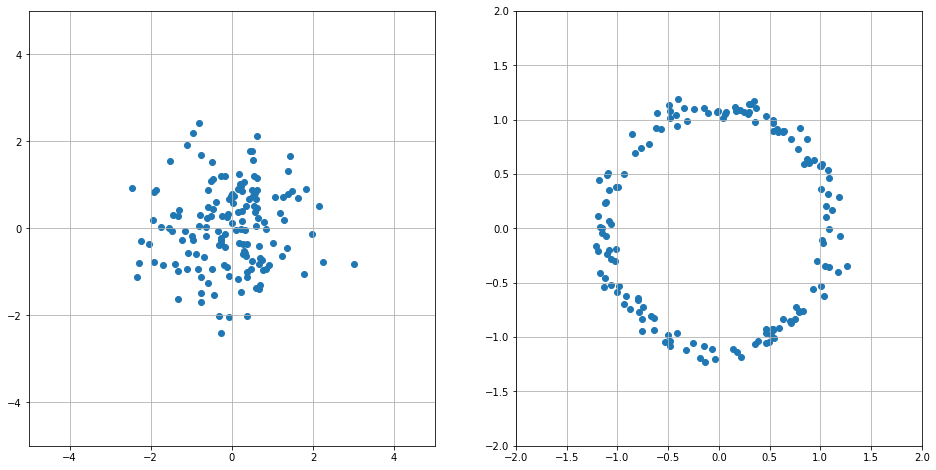

In [2]:
Z = np.random.randn(150, 2)
X = Z/(np.sqrt(np.sum(Z*Z, axis=1))[:, None]) + Z/10

fig, axs = plt.subplots(1, 2, sharex=False, figsize=(16,8))

ax = axs[0]
ax.scatter(Z[:,0], Z[:,1])
ax.grid(True)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax = axs[1]
ax.scatter(X[:,0], X[:,1])
ax.grid(True)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

Пример выше из ***[1]***

Таким образом, если подобрать правильные функции, то можно отобразить пространства скрытых переменных обычных автоэнкодеров в какие-то хорошие пространства, например такие, где распределение нормально. А потом обратно.

С другой стороны специально учиться отображать одни скрытые пространства в другие вовсе не обязательно. Если есть какие-то полезные скрытые пространства, то правильный автоэнкодер научится им по пути сам, но отображать, в конечно итоге, будет в нужное нам пространство.

***Вариационные автоэнкодеры*** (*Variational Autoencoders*) - это автоэнкодеры, которые учатся отображать объекты в заданное скрытое пространство и, соответственно, сэмплить из него. Поэтому *вариационные автоэнкодеры* относят так же к семейству генеративных моделей.

![](pics/03_vae_vae_diagram.png)  

Иллюстрация из ***[2]***

Далее выжимка теории из ***[1]*** лежащая в основе *VAE*.

Пусть $Z$ - скрытые переменные, а $X$ - данные. 
На примере нарисованых цифр рассмотрим естесственный генеративный процесс, который сгенерировал нашу выборку:
$$
P(X) = \int_{z} P(X|Z)P(Z)dZ
$$

- $P(X)$ вероятностное распределение изображений цифр на картинках, т.е. вероятность конкретного изображения цифры впринципе быть нарисованым (если картинка не похожа на цифру, то эта вероятность крайне мала, и наоборот),
- $P(Z)$ - вероятностное распределение скрытых факторов, например, распределение толщины штриха,
- $P(X|Z)$ - распределение вероятности картинок при заданных скрытых факторах, одни и те же факторы могут привезти к разным картинкам (один и тот же человек в одних и тех же условиях не рисует абсолютно одинаковые цифры)

Представим $P(X|Z)$ как сумму некоторой генерирующей функции $f(Z)$ и некоторого сложного шума $\epsilon$

$$
P(X|Z) = f(Z) + \epsilon
$$

Мы хотим построить некоторый искусственный генеративный процесс, который будет создавать объекты близкие в некоторой метрике к тренировачным $X$.

$$
P(X;\theta) = \int_{z} P(X|Z;\theta)P(Z)dZ \ \ \ (1)
$$
и снова
$$
P(X|Z;\theta) = f(Z;\theta) + \epsilon
$$

$f(Z;\theta)$ - некоторое семейсто функций, которое представляет наша модель, а $\theta$ - ее параметры. Выбирая метрику - мы выбираем то, какого вида нам представляется шум $\epsilon$. Если метрика $L_2$, то мы считаем шум нормальным и тогда:

$$
P(X|Z;\theta) = N(X|f(Z;\theta), \sigma^2 I),
$$

По принципу максимального правдоподобия нам остается оптимизировать параметры $\theta$ для того, чтобы максимизировать $P(X)$, т.е. вероятность появления объектов из выборки.

Проблема в том, что оптимизировтаь интеграл (1) напрямую мы не можем: пространство может быть высокоразмерное, объектов много, да и метрика плохая. С другой стороны, если задуматься, то к каждому конкретному $X$ может привезти лишь очень небольшое подмножество $Z$, для остальных же $P(X|Z)$ будет очень близок к нулю. 
И при оптимизации достаточно сэмплить только из хороших $Z$.

Для того чтобы знать из каких $Z$ нам надо сэмплить, введем новое распределение $Q(Z|X)$, которое в зависимости от $X$ будет показывать распределение $Z \sim Q$, которое могло привезти к этому $X$.

Запишем сперва расстояние Кульбака-Лейблера (несимметричная мера "похожести" двух распределений, подробнее ***[3]***) между
$Q(Z|X)$ и реальным $P(Z|X)$:

$$
KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log Q(Z|X) - \log P(Z|X)]
$$

Применяем формулу Байеса:

$$
KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log Q(Z|X) - \log P(X|Z) - \log P(Z)] + \log P(X)
$$

Выделяем еще одно расстояние Кульбака-Лейблера:

$$
KL[Q(Z|X)||P(Z|X)] = KL[Q(Z|X)||\log P(Z)] - \mathbb{E}_{Z \sim Q}[\log P(X|Z)] + \log P(X)
$$

В итоге получаем тождество:

$$
\log P(X) - KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z)] - KL[Q(Z|X)||P(Z)]
$$


Это тождество - краеугольный камень *вариационных автоэнкодеров*, оно верно для любых $Q(Z|X)$ и $P(X,Z)$.

Пусть $Q(Z|X)$ и $P(X|Z)$ зависят от параметров: $Q(Z|X;\theta_1)$ и $P(X|Z;\theta_2)$, а $P(Z)$ - нормальное $N(0,I)$, тогда получаем:

$$
\log P(X;\theta_2) - KL[Q(Z|X;\theta_1)||P(Z|X;\theta_2)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)] - KL[Q(Z|X;\theta_1)||N(0,I)]
$$

Взглянем повнимательнее на то, что у нас получилось:
- во-первых, $Q(Z|X;\theta_1)$, $P(X|Z;\theta_2)$ подозрительно похожи на энкодер и декодер (точнее декодер это $f$ в выражении $P(X|Z;\theta_2) = f(Z;\theta_2) + \epsilon$)
- слева в тождестве - значение, которое мы хотим максимизировать для элементов нашей тренировачной выборки $X$ + некоторая ошибка $KL$ ($KL(x,y) \ge 0 \ \ \forall x,y$), которая, будем надеяться, при достаточной емкости $Q$ уйдет в 0,
- справа значение, которое мы можем оптимизировать градиентным спуском, где первый член имеет смысл качества предсказания $X$ декодером по значениям $Z$, а второй член, это расстояние К-Л между распределением $Z \sim Q$, которое предсказывает энкодер для конкретного $X$, и распределением $Z$ для всех $X$ сразу

Для того, чтобы иметь возможность оптимизировать правую часть градиентным спуском, осталось разобраться с двумя вещами:
#### 1. Точнее определим что такое $Q(Z|X;\theta_1)$
Обычно $Q$ выбирается нормальным распределением:

$$
Q(Z|X;\theta_1) = N(\mu(X;\theta_1), \Sigma(X;\theta_1))
$$
То есть энкодер для каждого $X$ предсказывает 2 значения: среднее $\mu$ и вариацию $\Sigma$ нормального распределения, из которого уже сэмплируются значения. Работает это все примерно вот так:   
![](pics/03_vae_encoder_vae_diagram.png)  
Иллюстрация из ***[2]***


При том, что для каждой отдельной точки данных $X$ энкодер предсказывает некоторое нормальное распределение $P(Z|X) = N(\mu(X), \Sigma(X))$, для априорного распределения $Х$: $P(Z) = N(0, I)$, что получается из формулы, и это потрясающе.  
![](pics/03_vae_kl_divergence_diagram.png)  
Иллюстрация из ***[2]***


При этом $KL[Q(Z|X;\theta_1)||N(0,I)]$ принимает вид:  

$$
KL[Q(Z|X;\theta_1)||N(0,I)] = \frac{1}{2}\left(tr(\Sigma(X)) + \mu(X)^T\mu(X) - k - \log \det \Sigma(X) \right)
$$

#### 2. Разберемся с тем, как распространять ошибки через $\mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)]$
Дело в том, что здесь мы берем случайные значения $Z \sim Q(Z|X;\theta_1)$ и передаем их в декодер.
Ясно, что распросранять ошибки через случайные значения напрямую нельзя, поэтому используется так называемый *трюк с репараметризацией* (*reparametrization trick*).

Схема получается вот такая:  
![](pics/03_vae_reparam_trick.png)  
Иллюстрация из ***[1]***

Здесь на левой картинке схема без трюка, а на правой с трюком.
Красным цветом показано семплирование, а синим вычисление ошибки.  
То есть по сути просто берем предсказанное энкодером стандартное отклонение $\Sigma$ умножаем на случайное число из $N(0,I)$ и добавляем предсказанное среднее $\mu$.

Прямое растространение на обеих схемах абсолютно одинаковое, однако на правой схеме работает обратное распространение ошибки.

После того, как мы обучили такой вариационный автоэнкодер, декодер становится полноправной генеративной моделью. По сути и энкодер то нужен в основном для того, чтобы обучить декодер отдельно быть генеративной моделью.  
![](pics/03_vae_vae_decoder_diagram.png)  
Иллюстрация из ***[2]***  
<img src="./pics/03_vae_generator.png" width="300"/>  
Иллюстрация из ***[1]***  

Но то, что энкодер и декодер вместо образуют еще и полноценный автоэнкодер, это очень приятный плюс.

# VAE в Keras 

Теперь, когда мы разобрались в том, что такое вариационные автоэнкодеры, напишем такой на *Keras*

Зададим основные параметры. Скрытое пространство возьмем размерности 2, чтобы позже генерировать из него и визуализировать результат.  
***Замечание***: размерность 2 крайне мала, особенно в метрике $L_2$, поэтому следует ожидать, что цифры получатся очень размытыми.

In [ ]:
batch_size = 500
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001

Напишем модели вариационного автоэнкодера. 

Для того, чтобы обучение происходило быстрее и более качественно, добавим слои *dropout* и *batch normalization*.
А в декодере используем в качестве активации *leaky ReLU*, которую добавляем отдельным слоем после *dense* слоев без активации.

Функция *sampling* реализует сэмплирование значений $Z$ из $Q(X)$ с использованием трюка репараметризации.

*vae_loss* это правая часть из уравнения:

$$
\log P(X;\theta_2) - KL[Q(Z|X;\theta_1)||P(Z|X;\theta_2)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)] - \left(\frac{1}{2}\left(tr(\Sigma(X)) + \mu(X)^T\mu(X) - k - \log \det \Sigma(X) \right)\right)
$$

далее будет использоваться в качестве лосса.

In [ ]:
x_train, y_train, x_test, y_test = get_mnist()